# Hear4U


## Download Dataset

## Import Data

In [1]:
!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.1 MB/s eta 0:00:00


In [2]:
!pip install -q "tensorflow==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 25.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=

In [3]:
import os
import shutil
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [4]:
tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

   8192/Unknown - 0s 0us/step

'./datasets/esc-50.zip'

## Load Dataset

### Showing Data

In [5]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Filtered Label

In [6]:
my_classes = ['crying_baby', 'coughing', 'clapping', 'footsteps', 'laughing',
             'door_wood_knock', 'door_wood_creaks', 'clock_alarm', 'vacuum_cleaner',
             'glass_breaking', 'chainsaw', 'siren', 'car_horn', 'train',
             'church_bells', 'rain', 'thunderstorm', 'cat', 'dog', 'sheep']
map_class_to_id = {'crying_baby':0, 'coughing':1, 'clapping': 2, 'footsteps': 3, 'laughing': 4,
             'door_wood_knock': 5, 'door_wood_creaks': 6, 'clock_alarm': 7, 'vacuum_cleaner': 8,
             'glass_breaking': 9, 'chainsaw': 10, 'siren': 11, 'car_horn': 12, 'train': 13,
             'church_bells': 14, 'rain': 15, 'thunderstorm': 16, 'cat': 17, 'dog': 18, 'sheep': 19}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,18,dog,True,100032,A
2,1-100210-A-36.wav,1,8,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,8,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,16,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,16,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,5,door_wood_knock,False,101336,A
9,1-103995-A-30.wav,1,5,door_wood_knock,False,103995,A
10,1-103999-A-30.wav,1,5,door_wood_knock,False,103999,A
11,1-104089-A-22.wav,1,2,clapping,False,104089,A
12,1-104089-B-22.wav,1,2,clapping,False,104089,B


### Saved new CSV File with Predefined Labels

In [7]:
CSV_PATH = "./datasets/ESC-50-master/meta/esc20.csv"
# filtered_pd.to_csv(new_csv_path, index=False)

### Convert WAV to 16000hz and Filter Audio Based on Labels

In [8]:
# Function to load and convert WAV files
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, and resample to 16 kHz mono audio. """
    file_contents = tf.io.read_file("./datasets/ESC-50-master/audio/" + filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Function to save the converted WAV file
def save_wav_16k_mono(wav, filename):
    """ Save 16 kHz audio tensor to a WAV file. """
    wav = tf.expand_dims(wav, axis=-1)  # Add channels dimension
    encoded_wav = tf.audio.encode_wav(wav, sample_rate=16000)
    tf.io.write_file(filename, encoded_wav)

# Convert filtered audio files
def convert_filtered_audio_files(filtered_pd, output_path):
    """ Convert all filtered audio files to 16 kHz mono audio. """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for _, row in filtered_pd.iterrows():
        input_file_path = row['filename']
        output_file_path = os.path.join(output_path, os.path.basename(input_file_path))

        wav = load_wav_16k_mono(input_file_path)
        save_wav_16k_mono(wav, output_file_path)
        print(f"Converted {input_file_path} to {output_file_path}")

# Output path
output_path = './datasets/ESC-50-master/audio-16k/'
convert_filtered_audio_files(filtered_pd, output_path)


Converted 1-100032-A-0.wav to ./datasets/ESC-50-master/audio-16k/1-100032-A-0.wav
Converted 1-100210-A-36.wav to ./datasets/ESC-50-master/audio-16k/1-100210-A-36.wav
Converted 1-100210-B-36.wav to ./datasets/ESC-50-master/audio-16k/1-100210-B-36.wav


Converted 1-101296-A-19.wav to ./datasets/ESC-50-master/audio-16k/1-101296-A-19.wav
Converted 1-101296-B-19.wav to ./datasets/ESC-50-master/audio-16k/1-101296-B-19.wav
Converted 1-101336-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-101336-A-30.wav
Converted 1-103995-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-103995-A-30.wav
Converted 1-103999-A-30.wav to ./datasets/ESC-50-master/audio-16k/1-103999-A-30.wav
Converted 1-104089-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-104089-A-22.wav
Converted 1-104089-B-22.wav to ./datasets/ESC-50-master/audio-16k/1-104089-B-22.wav
Converted 1-105224-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-105224-A-22.wav
Converted 1-110389-A-0.wav to ./datasets/ESC-50-master/audio-16k/1-110389-A-0.wav
Converted 1-110537-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-110537-A-22.wav
Converted 1-115521-A-19.wav to ./datasets/ESC-50-master/audio-16k/1-115521-A-19.wav
Converted 1-115920-A-22.wav to ./datasets/ESC-50-master/audio-16k/1-115920-A-2

In [9]:
audio_16k_path = './datasets/ESC-50-master/audio-16k/'

# Menghitung jumlah file dalam folder
def count_files_in_folder(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Menghitung jumlah file dalam folder audio_16k
num_files = count_files_in_folder(audio_16k_path)
print(f"Jumlah file dalam folder '{audio_16k_path}': {num_files}")

Jumlah file dalam folder './datasets/ESC-50-master/audio-16k/': 800


### Move the Converted audio to the Labeled Folder

In [10]:
for category in my_classes:
    folder_path = os.path.join("./datasets/ESC-50-master/audio-16k/", category)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


all_audio_files = filtered_pd['filename'].tolist()


for audio_file in all_audio_files:
    category = filtered_pd[filtered_pd['filename'] == audio_file]['category'].values[0]
    if category in my_classes:
        # Tentukan jalur sumber dan tujuan file audio
        source_path = os.path.join("./datasets/ESC-50-master/audio-16k/", audio_file)
        destination_path = os.path.join("./datasets/ESC-50-master/audio-16k/", category, audio_file)
        shutil.move(source_path, destination_path)

print("File audio telah dipindahkan ke folder yang sesuai dengan kategorinya.")

File audio telah dipindahkan ke folder yang sesuai dengan kategorinya.


### Check total file each Label

In [11]:
counter = 0

for file in (my_classes):
    dir = os.listdir(f"{audio_16k_path}/{file}")

    print(f"Data for {file} is {len(dir)}")

Data for crying_baby is 40
Data for coughing is 40
Data for clapping is 40
Data for footsteps is 40
Data for laughing is 40
Data for door_wood_knock is 40
Data for door_wood_creaks is 40
Data for clock_alarm is 40
Data for vacuum_cleaner is 40
Data for glass_breaking is 40
Data for chainsaw is 40
Data for siren is 40
Data for car_horn is 40
Data for train is 40
Data for church_bells is 40
Data for rain is 40
Data for thunderstorm is 40
Data for cat is 40
Data for dog is 40
Data for sheep is 40


## Visualization

### Visualization each Label

In [12]:
#taking one sample on each label
sample_pd = filtered_pd.drop_duplicates(subset=["target"])
sample_pd

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,18,dog,True,100032,A
2,1-100210-A-36.wav,1,8,vacuum_cleaner,False,100210,A
4,1-101296-A-19.wav,1,16,thunderstorm,False,101296,A
6,1-101336-A-30.wav,1,5,door_wood_knock,False,101336,A
11,1-104089-A-22.wav,1,2,clapping,False,104089,A
24,1-116765-A-41.wav,1,10,chainsaw,True,116765,A
28,1-119125-A-45.wav,1,13,train,False,119125,A
29,1-121951-A-8.wav,1,19,sheep,False,121951,A
33,1-13571-A-46.wav,1,14,church_bells,False,13571,A
35,1-13613-A-37.wav,1,7,clock_alarm,False,13613,A


In [13]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for category in my_classes:
    category_path = os.path.join(audio_16k_path, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            try:
                signal, rate = librosa.load(file_path, sr=None)
                signals[category] = signal

                mel_spec = librosa.feature.melspectrogram(y=signal, sr=rate, n_fft=2048, hop_length=512)
                mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert from power to decibels
                mel_spectrograms[category] = mel_spec

                mfcc = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=13, dct_type=3)
                mfccs[category] = mfcc

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

### Visualization Sound Wave

In [28]:
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=4 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Plot Sound Wave', size=32)
    i=0
    for x in range(5):
        for y in range(4):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

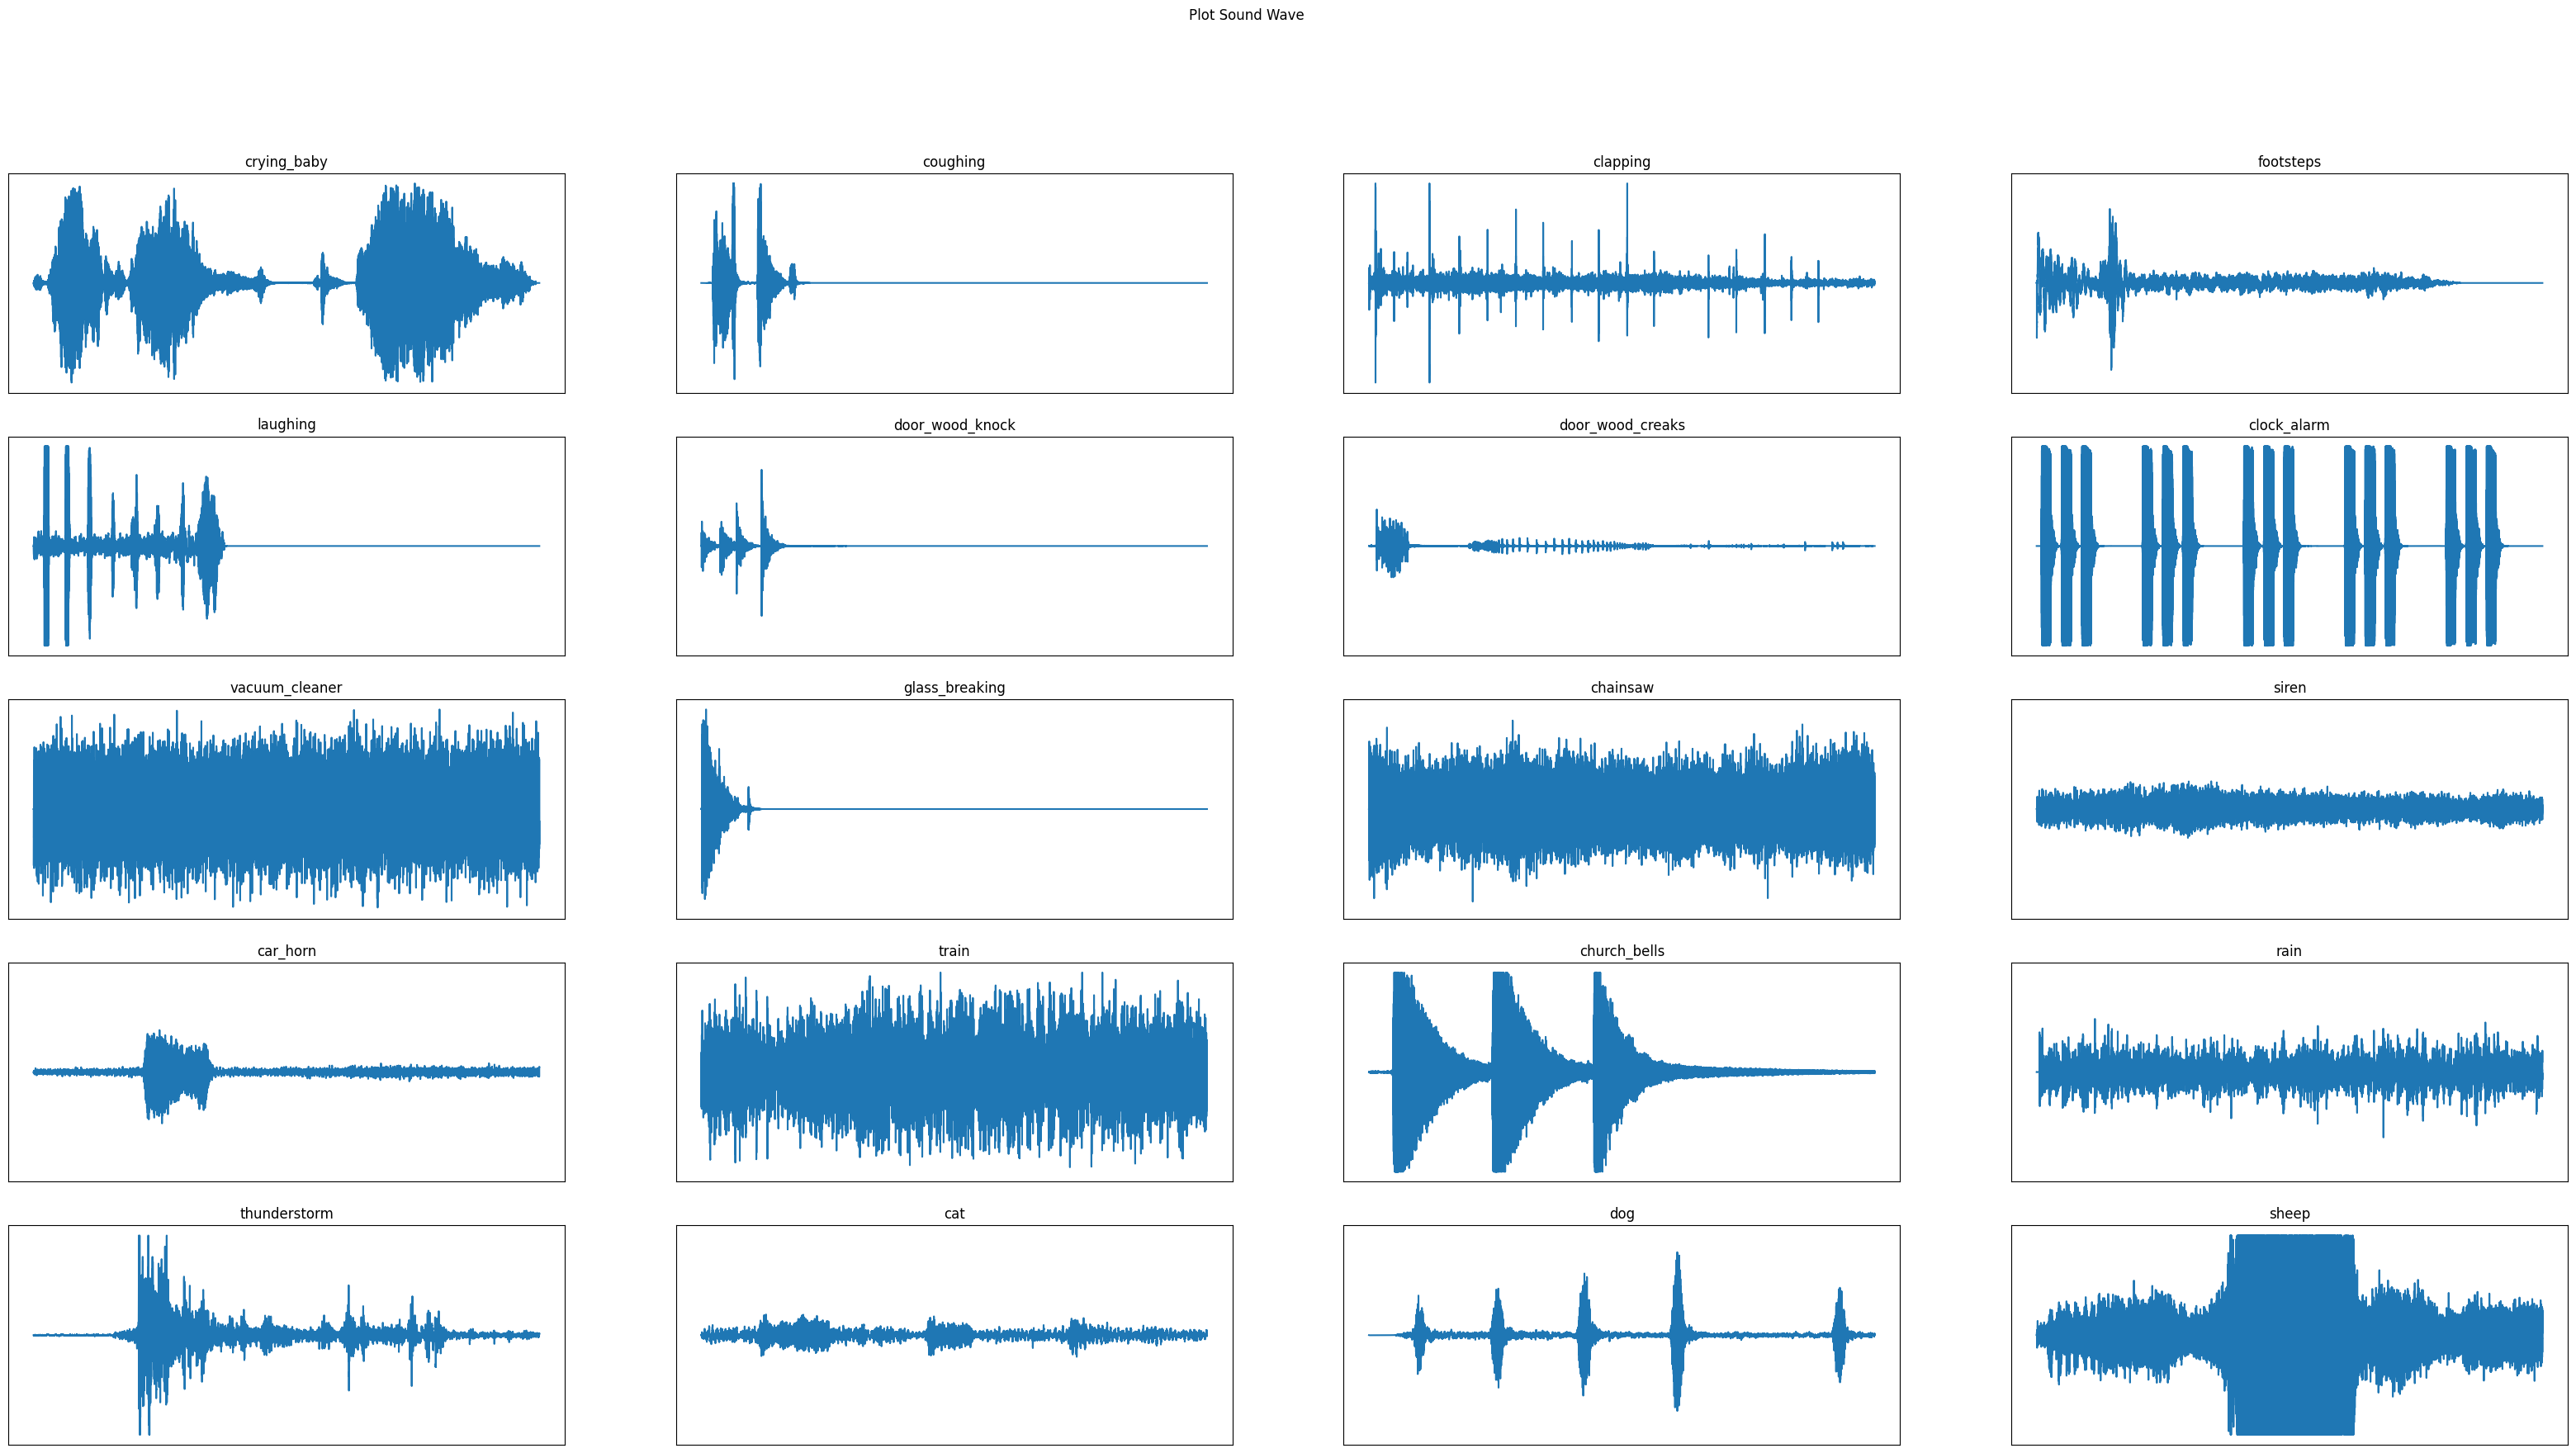

### Visualization Spectogram

In [32]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=4 , sharex=False, sharey=True , figsize=(20,10))
    fig.suptitle('Plot Spectogram')
    i=0
    for x in range(5):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

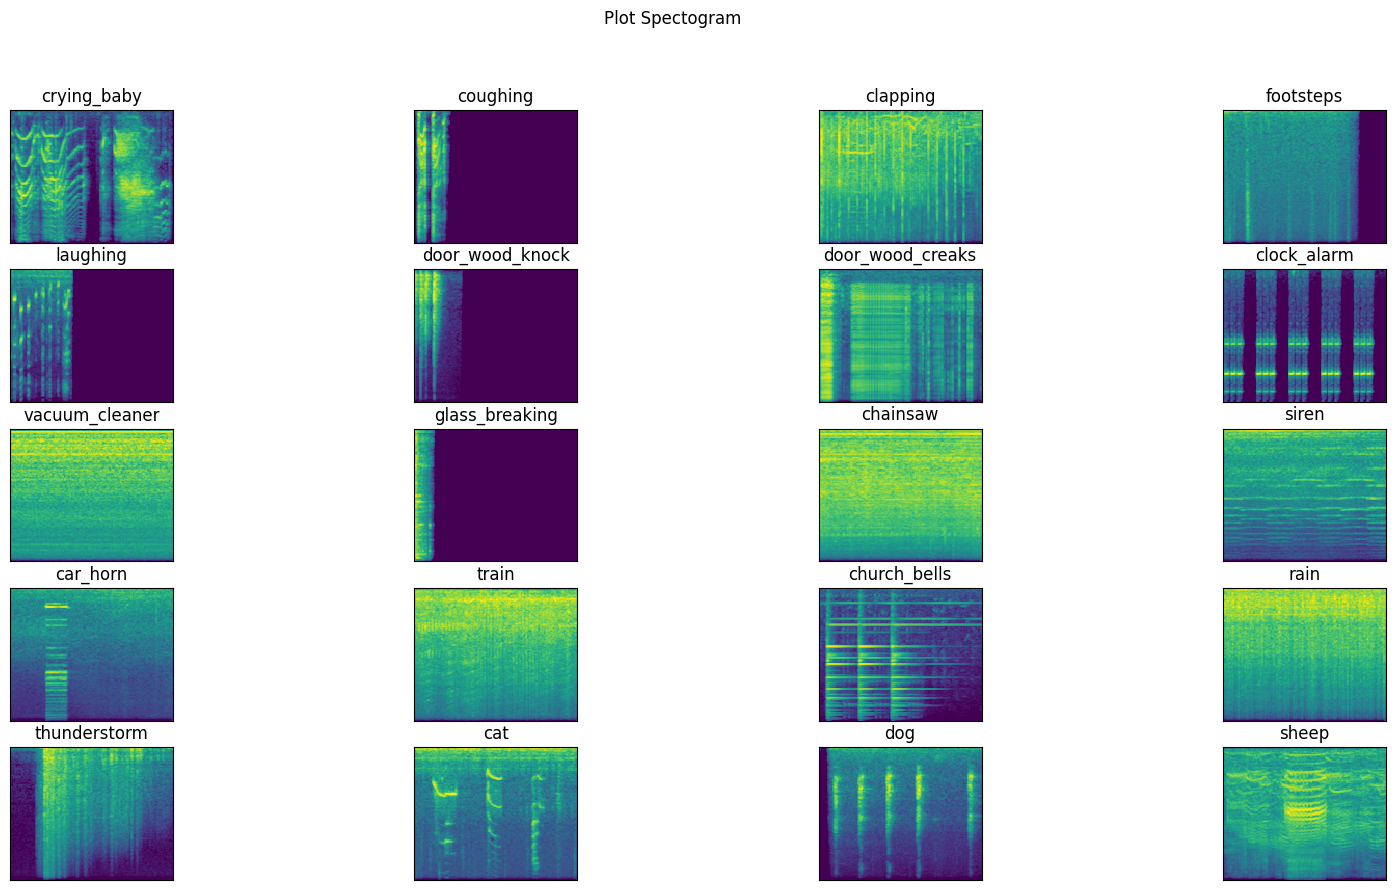

In [33]:
dis_feature(mel_spectrograms)